# 1. Datenimport

In [1]:
import pandas as pd
import csv

df = pd.read_excel(r'C:\Users\Dennis\Documents\9.Semester\Seminar\Quelle.xlsx')
print (df)
print(df.columns.ravel())

          Date  1 oz Sell  1 oz Buy  1/2 oz Sell  1/2 oz Buy  1/4 oz Sell  \
0   2018-01-03     5632.0    5415.0       2869.0      2708.0       1461.0   
1   2018-01-04     5579.0    5362.0       2842.0      2681.0       1447.0   
2   2018-01-05     5608.0    5391.0       2857.0      2696.0       1455.0   
3   2018-01-08     5585.0    5371.0       2845.0      2685.0       1449.0   
4   2018-01-09     5592.0    5377.0       2849.0      2688.0       1451.0   
..         ...        ...       ...          ...         ...          ...   
684 2020-10-23     8372.0    8047.0       4265.0      4023.0       2172.0   
685 2020-10-26     8386.0    8044.0       4272.0      4022.0       2176.0   
686 2020-10-27     8413.0    8086.0       4286.0      4043.0       2183.0   
687 2020-10-28     8424.0    8087.0       4292.0      4043.0       2186.0   
688 2020-10-30     8245.0    7915.0       4200.0      3957.0       2139.0   

     1/4 oz Buy  
0        1354.0  
1        1341.0  
2        1348.0  
3  

 ## 2. Data Handling

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [3]:
timestamp, selling = [], []  
timestamp = pd.DatetimeIndex(df['Date']).date
selling = df["1 oz Sell"]
X = selling.values
split = round(len(X) / 2)
Half1, Half2 = X[0:split], X[split:]
time1, time2 = timestamp[0:split], timestamp[split:]
meanH1, meanH2 = Half1.mean(), Half2.mean()
varH1, varH2 = Half1.var(), Half2.var()
print('meanH1=%f, meanH2=%f' % (meanH1, meanH2))
print('varianceH1=%f, varianceH2=%f' % (varH1, varH2))

meanH1=5494.976744, meanH2=7290.466667
varianceH1=22011.400622, varianceH2=739592.440193


In [4]:
dfges = pd.DataFrame({'timestamp': timestamp, 'selling': selling})
df1 = pd.DataFrame({'timestamp1': time1, 'selling1': Half1})
df2 = pd.DataFrame({'timestamp2': time2, 'selling2': Half2})
gesdiff = dfges.diff()
diff2 = df2.diff()
sellges = gesdiff["selling"].values
sell2 = diff2["selling2"].values
sellges[0] = 0
sell2[0] = 0

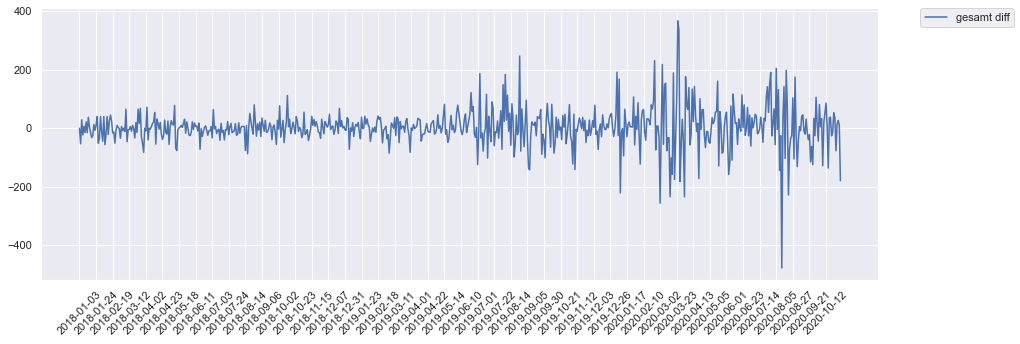

In [5]:
plt.figure(figsize = (15, 5))
plt.plot(gesdiff["selling"], label = "gesamt diff")
plt.xticks(np.arange(len(timestamp))[::15], timestamp[::15], rotation = '45')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

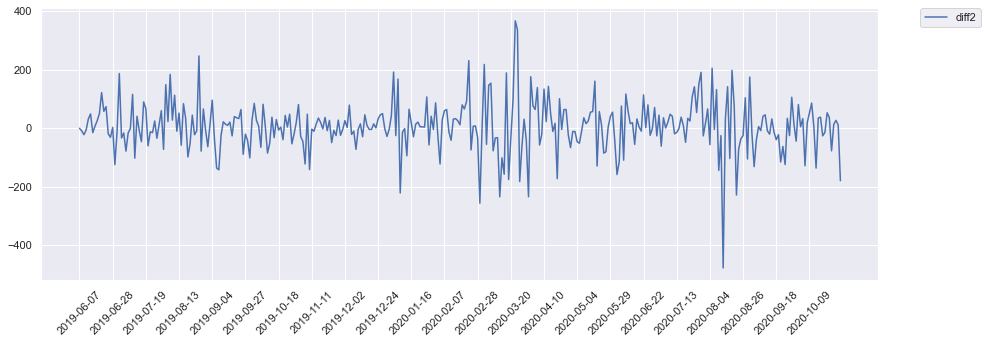

In [6]:
plt.figure(figsize = (15, 5))
plt.plot(diff2["selling2"], label = "diff2")
plt.xticks(np.arange(len(time2))[::15], time2[::15], rotation = '45')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## 3. Erstellen der Trainings- und Testsets
#### Dabei wird darauf geachtet, dass wir immer genau 61 Tage für das Backtesting zur Verfügung haben.

In [7]:
# Zeitreihe ohne Datenmanipulation
train_selling= selling[:628]
test_selling = selling[628:]

future_count = len(test_selling)
print(future_count)

train_selling_2nd_Half = Half2[:284]
test_selling_2nd_Half = Half2[284:]

#print(len(test_selling_2nd_Half))

# Differenzierte Zeitreihe
train_selling_diff = sellges[:628]
test_selling_diff = sellges[628:]

train_selling_2nd_Half_diff = sell2[:284]
test_selling_2nd_Half_diff = sell2[284:]


61


In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# 4. Modelldefinition

In [9]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


# 4.1 Parameterwahl LSTM

In [10]:
num_layers = 1
size_layer = 128
epoch = 500
dropout_rate = 0.6
skip = 10

# 4.2 Datentransformation
#### Die Zeitreihe wird mittels MinMax Verfahren auf das Intervall [0;1] skaliert.
#### Neuronale Netze funktionieren dann gewöhnlich besser.

In [11]:
from sklearn.preprocessing import MinMaxScaler
df = pd.DataFrame({'values': train_selling})
minmax = MinMaxScaler().fit(df)
df_log = minmax.transform(df)
df_log = pd.DataFrame(df_log)
print(df_log.head())

df2 = pd.DataFrame({'values': train_selling_2nd_Half})
minmax = MinMaxScaler().fit(df2)
df2_log = minmax.transform(df2)
df2_log = pd.DataFrame(df2_log)
print(df2_log.head())

df3 = pd.DataFrame({'values': train_selling_diff})
minmax = MinMaxScaler().fit(df3)
df3_log = minmax.transform(df3)
df3_log = pd.DataFrame(df3_log)
print(df3_log.head())

df4 = pd.DataFrame({'values': train_selling_2nd_Half_diff})
minmax = MinMaxScaler().fit(df4)
df4_log = minmax.transform(df4)
df4_log = pd.DataFrame(df4_log)
print(df4_log.head())

          0
0  0.141029
1  0.126899
2  0.134631
3  0.128499
4  0.130365
          0
0  0.012358
1  0.009352
2  0.002004
3  0.000000
4  0.010688
          0
0  0.410915
1  0.325843
2  0.457464
3  0.373997
4  0.422151
          0
0  0.410915
1  0.396469
2  0.375602
3  0.401284
4  0.462279


# 4.3 Modell mit Parametern

In [12]:
modelnn = Model(
    learning_rate = 0.001, 
    num_layers = num_layers, 
    size = df_log.shape[1], 
    size_layer = size_layer, 
    output_size = df_log.shape[1], 
    forget_bias = dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


## 4.4.1. Modelltraining mit kompletter Zeitreihe

In [13]:
%%time

for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, skip):
        index = min(k + skip, df_log.shape[0] -1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.0008661198324209712
epoch: 200 avg loss: 0.000785393205698226
epoch: 300 avg loss: 0.0007401224469173361
epoch: 400 avg loss: 0.0006802001650483412
epoch: 500 avg loss: 0.0008551042793026012
Wall time: 2min 59s


## 4.4.2 Erstellung der Vorhersage 

In [14]:
df = pd.DataFrame({'values': train_selling})
minmax = MinMaxScaler().fit(df)
df_log = minmax.transform(df)
df_log = pd.DataFrame(df_log)
future_day = future_count

output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]

## 4.4.3. Rücktransformation der Werte & Plot

In [15]:
df_log = minmax.inverse_transform(output_predict)

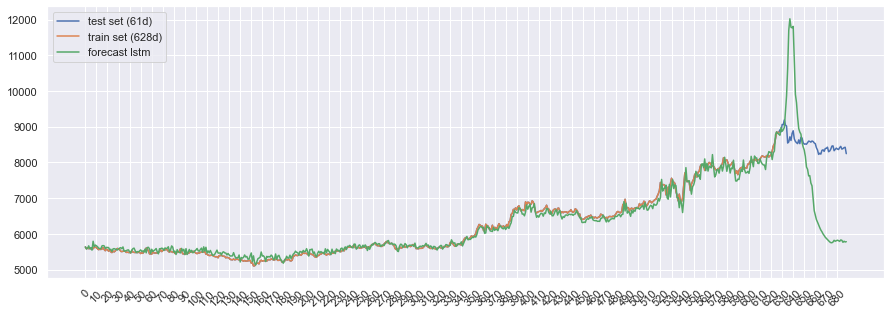

In [16]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test set (61d)')
ax.plot(train_selling, label = 'train set (628d)')
ax.plot(df_log, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

## 4.5.1. Modelltraining nur mit der zweiten Hälfte der Daten

In [17]:
%%time

for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df2_log.shape[0] - 1, skip):
        index = min(k + skip, df2_log.shape[0] -1)
        batch_x = np.expand_dims(
            df2_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df2_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df2_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.0013669595266725249
epoch: 200 avg loss: 0.001246022337565508
epoch: 300 avg loss: 0.0016694891588620894
epoch: 400 avg loss: 0.001899807250321359
epoch: 500 avg loss: 0.0015634826322574852
Wall time: 1min 16s


## 4.5.2. Erstellung der Vorhersage

In [18]:
df2 = pd.DataFrame({'values': train_selling_2nd_Half})
minmax = MinMaxScaler().fit(df2)
df2_log = minmax.transform(df2)
df2_log = pd.DataFrame(df2_log)
future_day = future_count

output_predict = np.zeros((df2_log.shape[0] + future_day, df2_log.shape[1]))
output_predict[0] = df2_log.iloc[0]
upper_b = (df2_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df2_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df2_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df2_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df2_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df2_log.shape[0] + 1] = out_logits
    df2_log.loc[df2_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df2_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df2_log.shape[0]] = out_logits[-1]
    df2_log.loc[df2_log.shape[0]] = out_logits[-1]

## 4.5.3. Rücktransformation der Werte & Plot

In [19]:
df2_log = minmax.inverse_transform(output_predict)

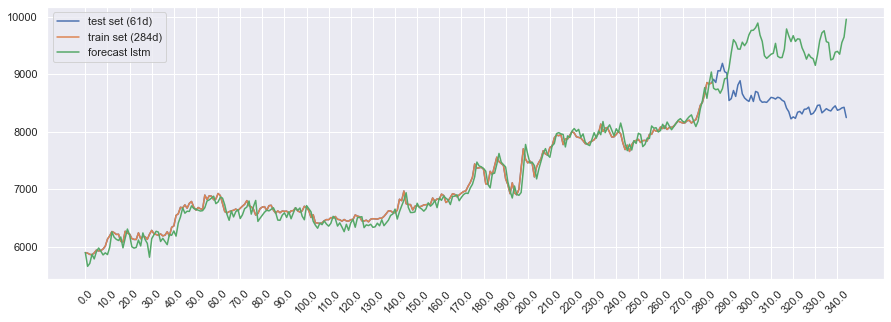

In [20]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(Half2, label = 'test set (61d)')
ax.plot(train_selling_2nd_Half, label = 'train set (284d)')
ax.plot(df2_log, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp)/2)[::10],
    np.arange(len(timestamp)/2)[::10],
    rotation = '45',
)
plt.legend()
plt.show()

## 4.6.1. Modelltraining mit differenzierter Zeitreihe 

In [21]:
%%time

for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df3_log.shape[0] - 1, skip):
        index = min(k + skip, df3_log.shape[0] -1)
        batch_x = np.expand_dims(
            df3_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df3_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df3_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.00925771599639938
epoch: 200 avg loss: 0.007602247040084915
epoch: 300 avg loss: 0.006877374268089387
epoch: 400 avg loss: 0.005519662574683709
epoch: 500 avg loss: 0.006760361809929627
Wall time: 2min 40s


## 4.6.2. Erstellung der Vorhersage

In [22]:
df3 = pd.DataFrame({'values': train_selling_diff})
minmax = MinMaxScaler().fit(df3)
df3_log = minmax.transform(df3)
df3_log = pd.DataFrame(df3_log)
future_day = future_count

output_predict = np.zeros((df3_log.shape[0] + future_day, df3_log.shape[1]))
output_predict[0] = df3_log.iloc[0]
upper_b = (df3_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df3_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df3_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df3_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df3_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df3_log.shape[0] + 1] = out_logits
    df3_log.loc[df3_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df3_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df3_log.shape[0]] = out_logits[-1]
    df3_log.loc[df3_log.shape[0]] = out_logits[-1]

## 4.6.3. Rücktransformation der Werte & Plot

In [23]:
df3_log = minmax.inverse_transform(output_predict)

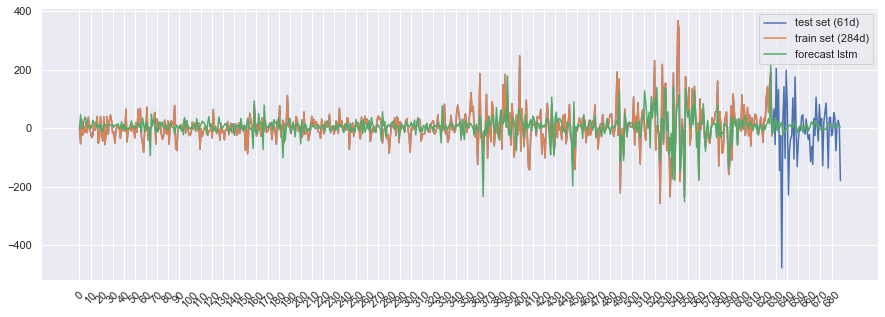

In [24]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(sellges, label = 'test set (61d)')
ax.plot(train_selling_diff, label = 'train set (284d)')
ax.plot(df3_log, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

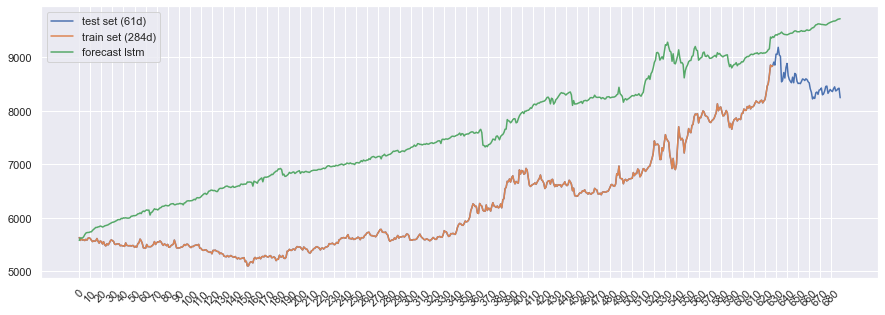

In [50]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test set (61d)')
ax.plot(train_selling , label = 'train set (284d)')
ax.plot(np.cumsum(df3_log) + selling[1], label = "forecast lstm")
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

## 4.7.1. Modelltraining mit differenzierter Zeitreihe (zweite Hälfte der Daten)

In [ ]:
%%time

for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df4_log.shape[0] - 1, skip):
        index = min(k + skip, df4_log.shape[0] -1)
        batch_x = np.expand_dims(
            df4_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df4_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df4_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

## 4.7.2. Erstellung der Vorhersage

In [34]:
df4 = pd.DataFrame({'values': train_selling_2nd_Half_diff})
minmax = MinMaxScaler().fit(df4)
df4_log = minmax.transform(df4)
df4_log = pd.DataFrame(df4_log)
future_day = future_count

output_predict = np.zeros((df4_log.shape[0] + future_day, df4_log.shape[1]))
output_predict[0] = df4_log.iloc[0]
upper_b = (df4_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df4_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df4_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df4_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df4_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df4_log.shape[0] + 1] = out_logits
    df4_log.loc[df4_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df4_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df4_log.shape[0]] = out_logits[-1]
    df4_log.loc[df4_log.shape[0]] = out_logits[-1]

## 4.7.3. Rücktransformation der Werte & Plot

In [35]:
df4_log = minmax.inverse_transform(output_predict)

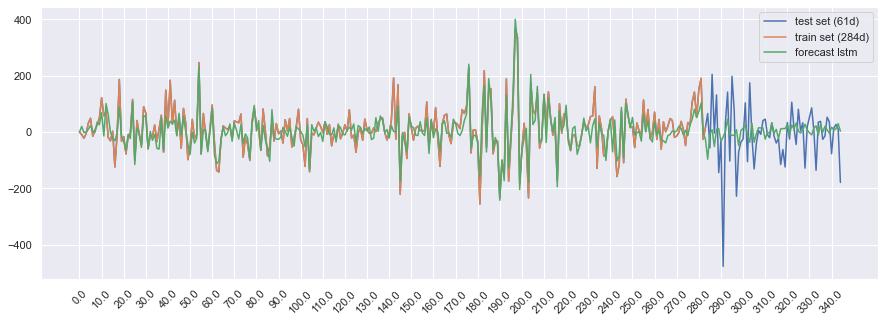

In [36]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(sell2, label = 'test set (61d)')
ax.plot(train_selling_2nd_Half_diff, label = 'train set (284d)')
ax.plot(df4_log, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp)/2)[::10],
    np.arange(len(timestamp)/2)[::10],
    rotation = '45',
)
plt.legend()
plt.show()

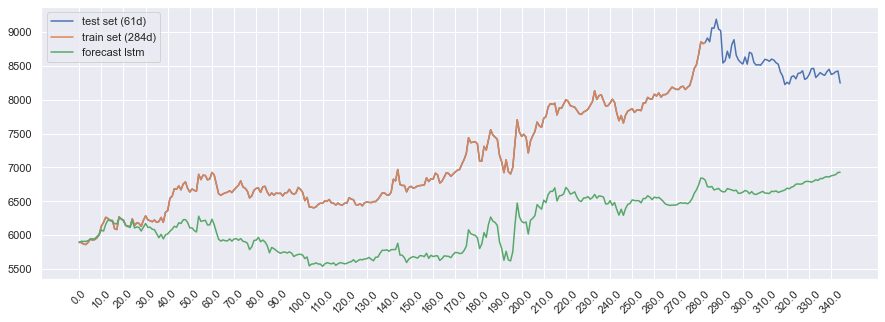

In [48]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(Half2, label = 'test set (61d)')
ax.plot(train_selling_2nd_Half , label = 'train set (284d)')
ax.plot(np.cumsum(df4_log) + df2.values[1], label = "forecast lstm")
plt.xticks(
    np.arange(len(timestamp)/ 2)[::10],
    np.arange(len(timestamp)/ 2)[::10],
    rotation = '45',
)
plt.legend()
plt.show()